cs231n Lecture 10
# RNN-LSTM 

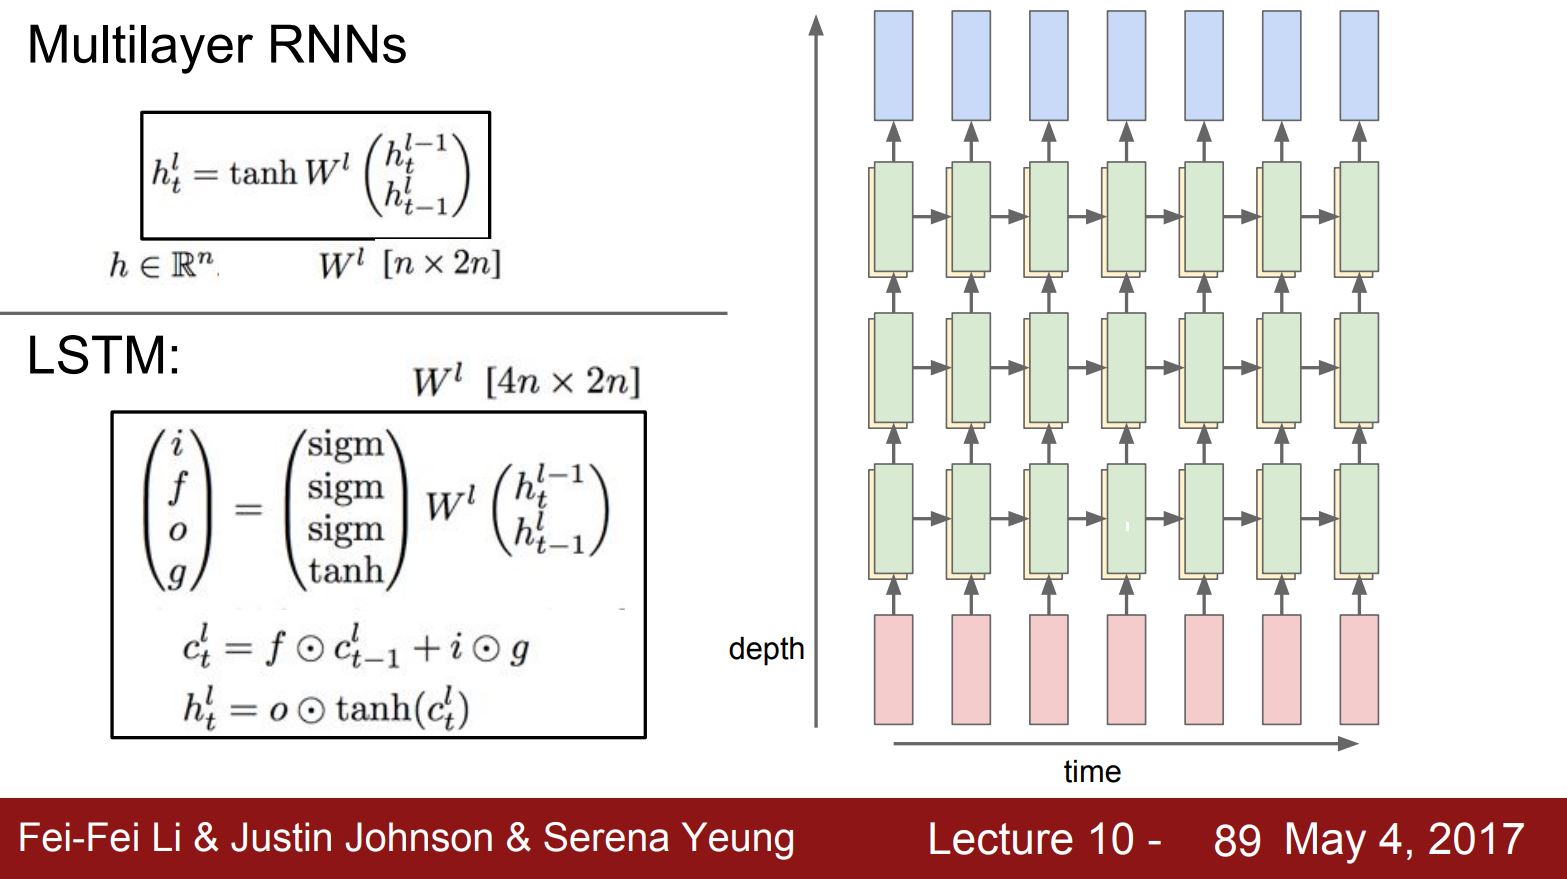

RNN: *multilayer* RNN으로 이용함.

모델이 깊어질수록 성능이 좋아짐

Input → 1st Hidden States → Hidden states sequence(input) → 2nd Hidden States.. 이런 식으로 계속 RNN layer을 쌓아올림

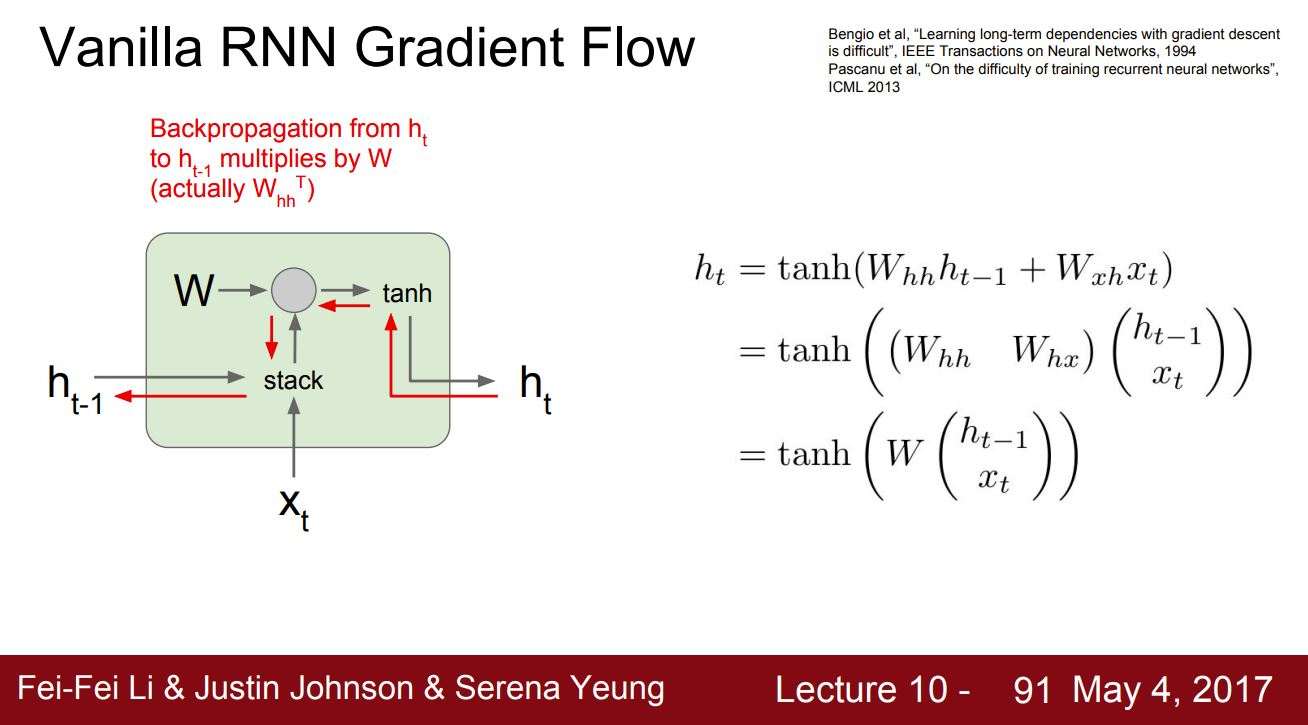

**Vanilla RNN cell**

input: **Xt** + output of previous hidden state: **h(t_1)** 이렇게 두 입력을 stack 후 weight W와 곱 연산, 그 후 tanh 씌워서 **hidden state(h(t))**가 만들어짐

vanilla RNN은 한 layer의 output인 **ht**는 h(t_1)이랑 xt의 두 input을 받아서 1. tanh gate 통과시킨 후 2. mat mul gate를 통과시키며 진행한다.

그런데 이제 이 *mat mul gate*를 통과시킬 때 **backpropagation**을 보자. 역전파에서 transpose를 곱하는 연산을 한다.

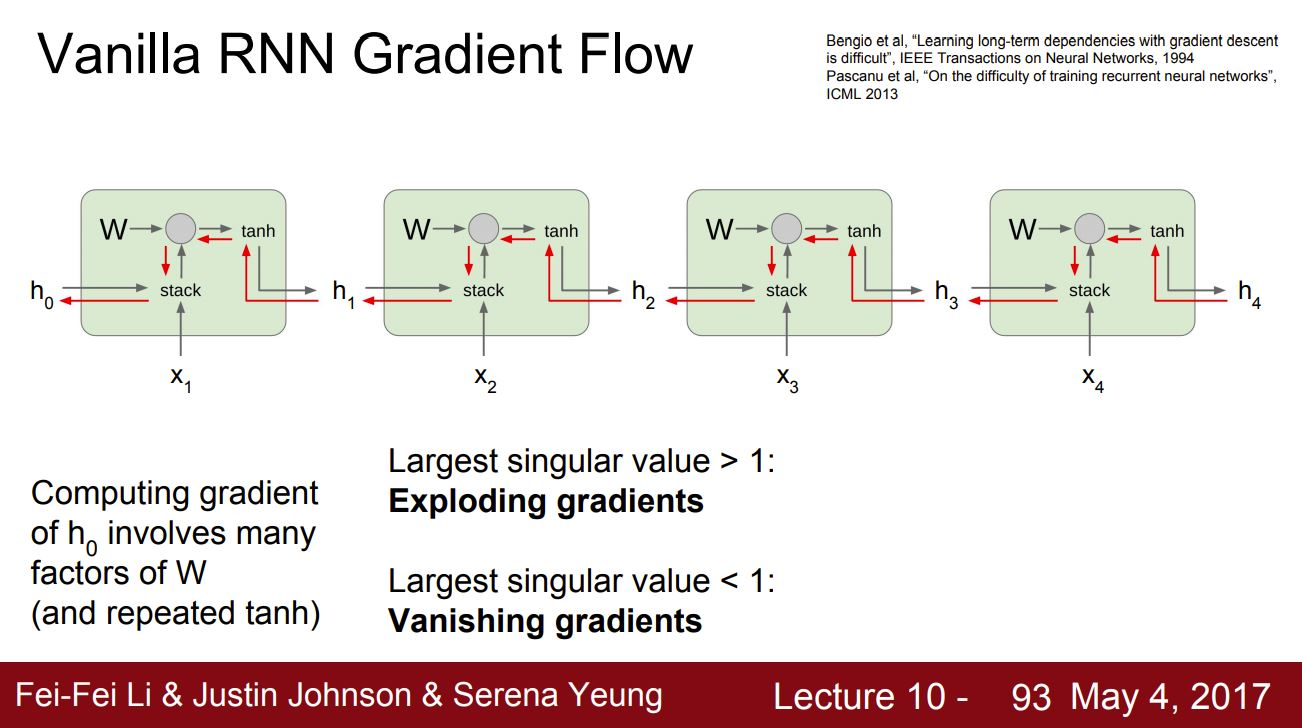

그래서 이제 가장 처음 input인 **h0의 gradient**를 구하기 위해서는 굉장히 많은 횟수의 W을 곱하는 연산이 수행된다.

결국 그 과정에서 모든 RNN Cell들을 거쳐야 한다. Cell 하나를 통과할 때마다 mat mul gate가 있으므로 각 cell의 *W transpose factor*가 관여하며 이런 과정들이 계속되어 아주 많은 W가 관여하게 된다.

이렇게 W를 많이 곱하는 것은 별로 안 좋다.

> Largest singular value > 1: Exploding gradients

1보다 큰 것을 많이 곱하면 layer가 deep해질수록, gradient가 기하급수적으로 **증가**한다.

> Largest singular value < 1: Vanishing gradients

1보다 작으면, 역시 layer가 deep해질수록 gradient가 기하급수적으로 **감소**한다.

따라서 이런 exploding이나 vanishing 같은 일이 일어나지 않으려면 largest singular value 값이 1이어야 하는데 그렇게 딱 1이 되는 게 쉽지가 않다.

그래서 기존의 Vanilla RNN에서 gradient의 exploding을 막기 위해서는 *gradient clipping*이라는 trick을 썼다.

```python
grad_norm = np.sum(grad * grad)
if grad_norm > threshold:
    grad *= (threshold / grad_norm)
```

이 방법은 grad_norm이 L2 value보다 클 경우에 최대 임계값을 넘지 못하도록 조정하도록 한다.

그런데 이제 vanishing gradient problem 특성상, 그리고 gradient clipping을 사용하는 방법이 근본적인 구조를 바꾸는 것이 아닌 trick에 불과하다는 특성상, **architecture** 자체를 바꾸려는 시도가 생겼다. 그렇게 나타난 게 **Long Short Term Memory, LSTM**이다.

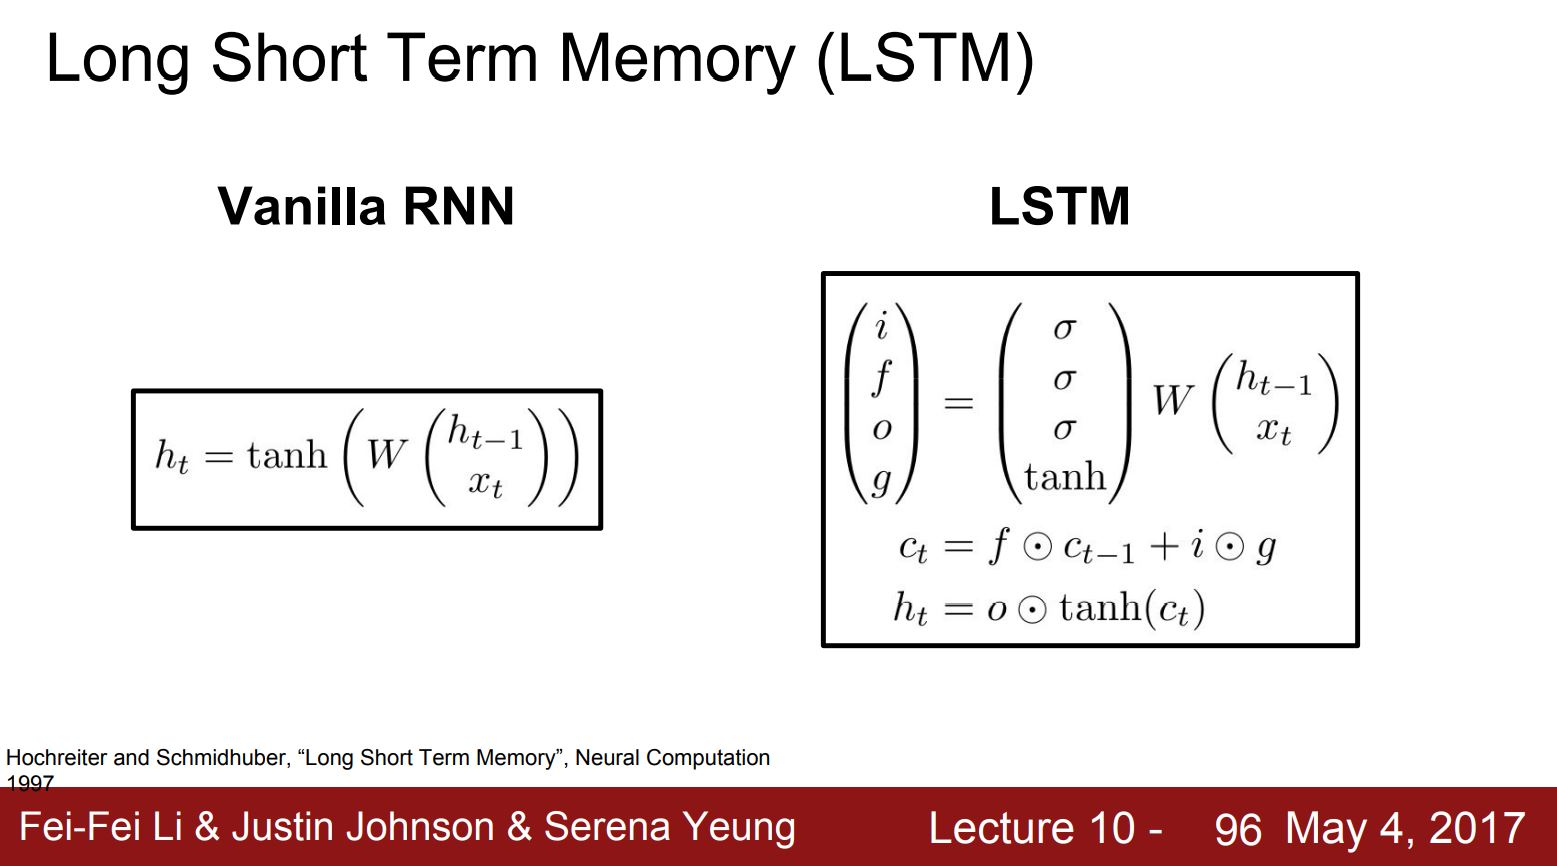

그래서 Vanilla RNN은 hidden state가 있고 이걸 recursive하게 update했다.

LSTM은 이런 RNN의 개념을 가지고 가되, 좀 더 *fancy*하게 만들어 놓았은 구조이다. 기존 RNN에서 문제가 되었떤 vanishing & exploding gradeint problem을 완화시키기 위해 디자인된 모델이다.

- **LSTM**은 cell*당* 2개의 hidden state를 가지고 있다.
  - 1. h(t_1)
  - 2. ct

이때 cell state는 LSTM 내부에만 존재되며, 노출되지 않는다. 


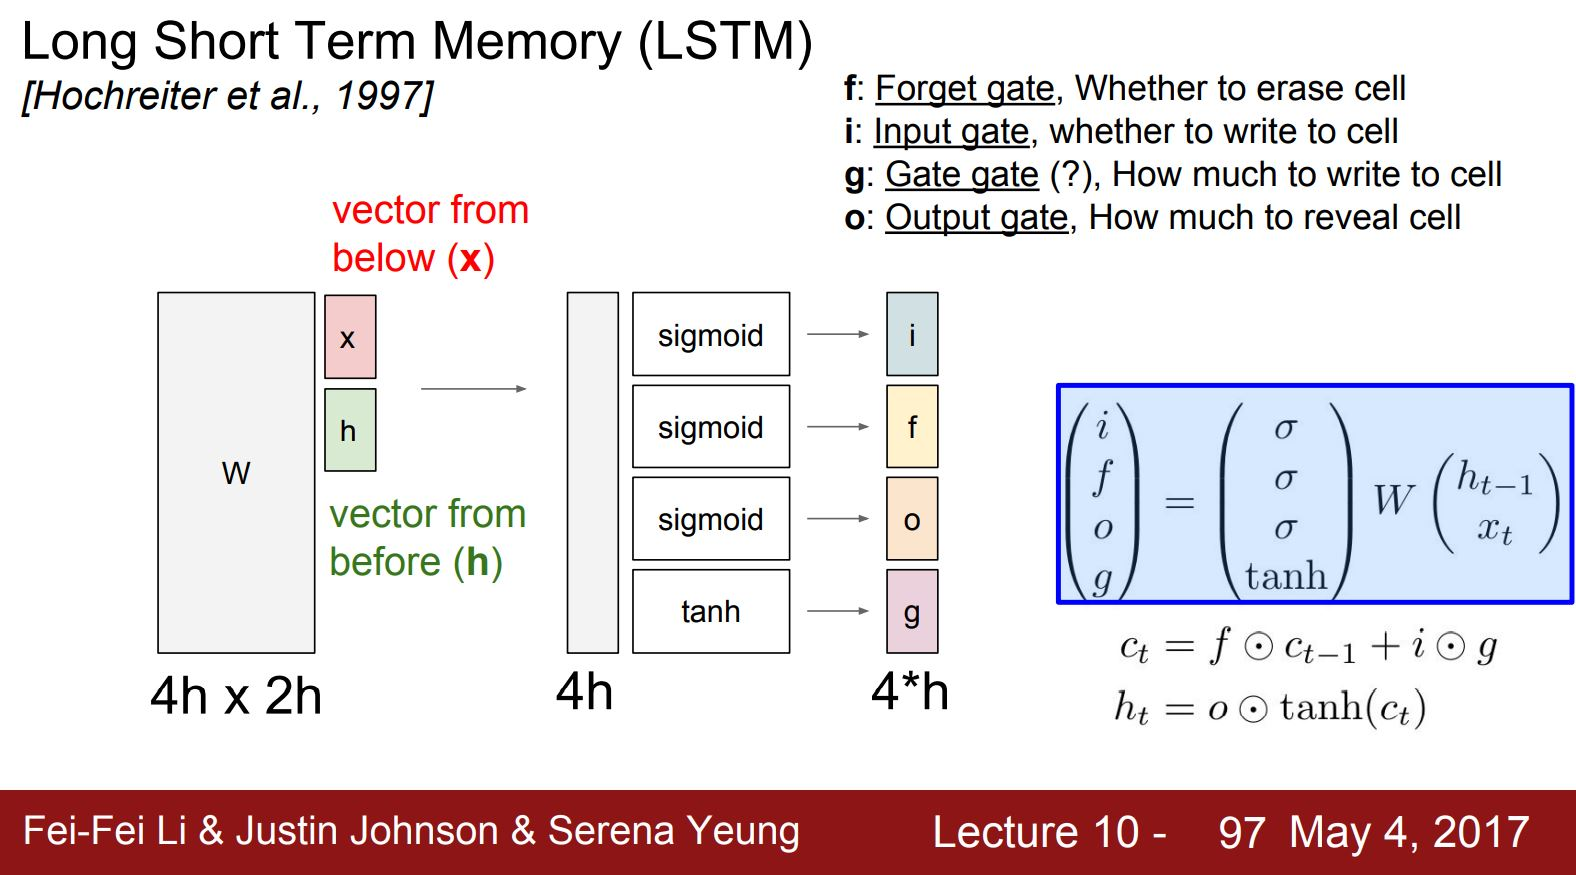

두 개의 input을 넣어서 4개의 gate를 계산하는데, 이렇게 계산하면 cell states Ct update에 사용된다. 그리고 Ct는 이제 다시 다음 step의 hidden states update된다.

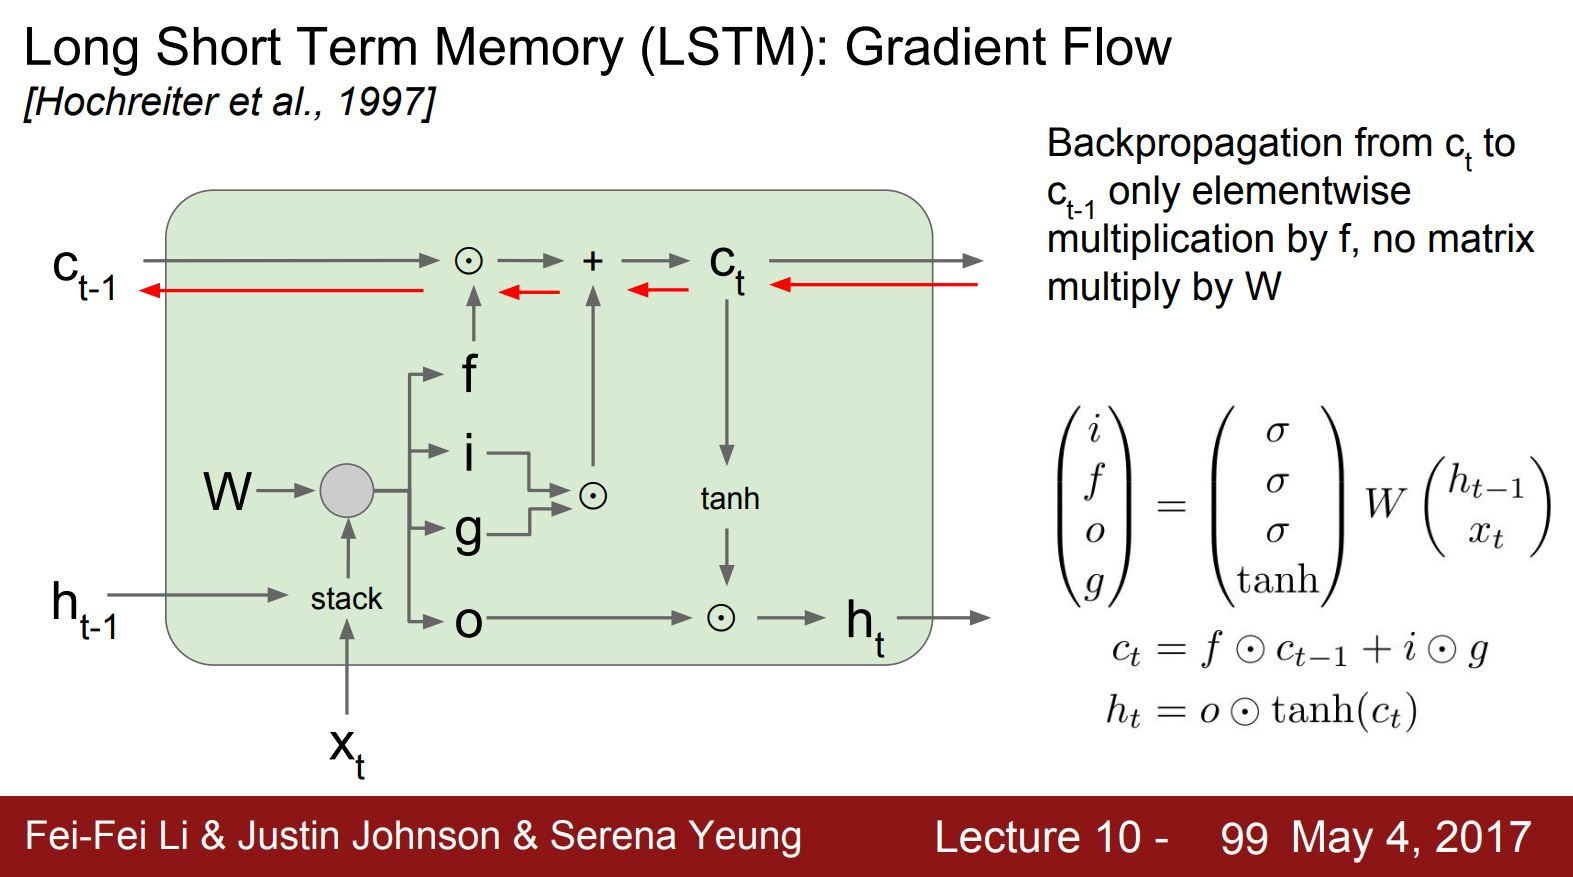

일단 ht_1을 넣고  → 그걸 stack으로 쌓아서, 4개 gradient value를 계산하기 위해 W를 곱해 준다. → 그리고 figo 각 gate에 대한 결과를 출력한다. (이때 각 gate의 출력은 hidden states의 크기와 동일하다.) → 그릐고 cell state 계산!

LSTM의 **ct에 대한 식**을 보자.

- ct: 독립적인 scalar value f, i에 의하여 조정된다.
  - 즉, 이전 cell state인 ct_1을 기억할지 말지를 결정하는 것이다.
  
- $ f ⊙ c(t-1)$ 식을 이용하여 **이전 state를 기억할지 말지** 선택한다.
  - $ f = 1 $ : cell state가 element를 *계속 기억*하도록 한다.
  - $ f = 0 $ : 이전 cell state를 forget 하도록 한다.

- $ i ⊙ g $ 식을 이용하여 **cell state의 각 요소를 증가시키거나 감소시킨다.** (최대 1)
  - g의 범위는 [-1, 1] 이고 i의 범위는 [0, 1] 이다. 그래서 최대 1이 나온다
  - cell state의 각 요소가 늘었다 줄었다 할 수 있다.

cell state를 계산한 후에는 → hidden state를 업데이트한다. ct는 LSTM 안에서만 나타나는 것이지만 hidden state은 ht는 밖에서도 보여지며 다음 net의 input이 되는 값이다. 

그래서 cell state는 counter의 개념으로 해석해서 스텝마다 최대 1, -1씩 센다. cell state에 tanh 통과해서 output gate랑 곱해서 최종 **ht**가 된다.

- output gate는 sigmoid의 결괏값(o)이며 sigmoid에서 나왔기 때문에 그 범위는 [0, 1]이다. **다음 hidden state를 계산할 때 cell state를 얼마나 노출시킬지**를 결정한다.

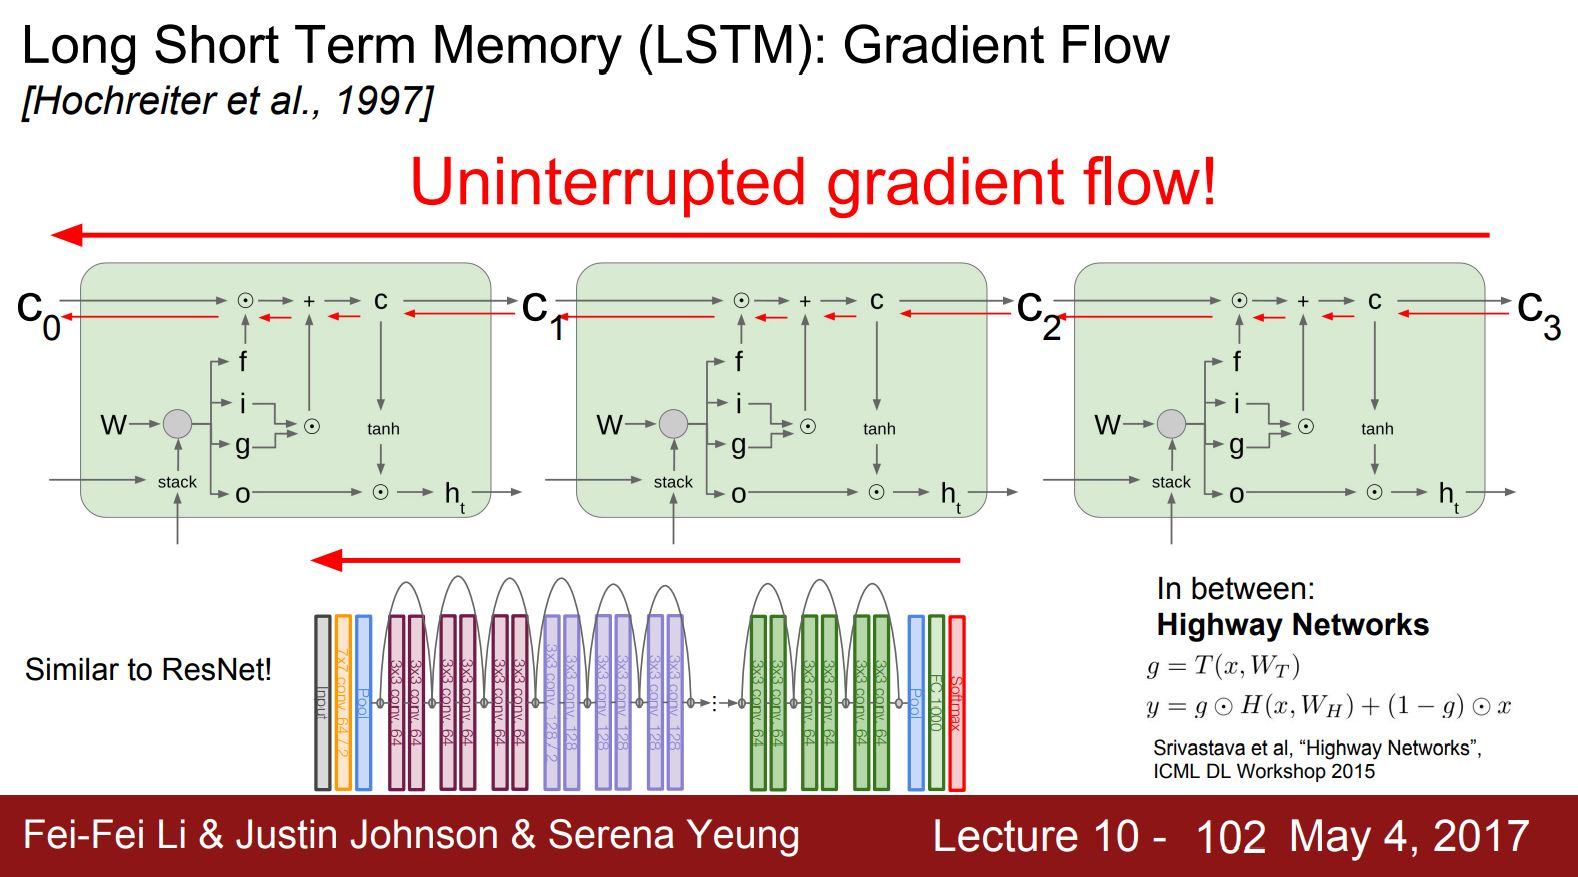

LSTM의 **backward pass**를 보자. 과연 Vanilla RNN의 문제가 해결되었을까? 

많이 해결되었다고 본다. 왜냐하면 **addition operation**의 back propagation이 있기 때문인데.. backprop compute 과정에서 addition operation이기 때문에 그저 upstream gradient가 두 개로 복사되는 거다. 

그래서 *gradient*는 **upstream gradient * forget gate** 이다.

이는 이점이 있다고 하는데..
- 1. forget gate와 곱해지는 연산이 matrix multiplication 아닌 *element-wise*
- 2. element wise multiplication을 통해 매 step *다른 값의 forget gate*와 곱해질 수 있음
  - vanilla는 $h_t$만을 계속 곱했고, 이가 exploding/vanishing gradient prob 나옴
  - **forget gate가 스텝마다 계속 변해서 해결 가능.**

- forget gate: sigmoid의 추출값으로 [0, 1] 사이의 multply 값을 가지고 있다. 그래서 forget gate를 반복적으로 곱할 때 더 좋은 수치적 특징을 보일 수 있다고 한다.

- 그리고 tahn을 단 한 번만 거치게 될 수 있어서 좋당.

---

정리하자면 LSTM의 이점은
1. every step, f changes
2. full mat mul(vanilla) -> element-wise application(LSTM)

이 두 개고 backward pass에서 identity mapping(connection) 유용하게 이용하는 ResNet이랑 좀 닮았다.